# Adaptive Transmission of Medical Images over Bandwidth-Limited Networks

**Goal:** Build an end-to-end pipeline to **compress and transmit medical images** under bandwidth constraints and channel impairments (noise/packet loss), and evaluate **rate–distortion** and downstream utility.

**Deliverables:**
- JPEG baseline: PSNR/SSIM vs bitrate
- Learned compression: autoencoder + quantization
- Channel simulation: packet loss + noise
- Optional: downstream classification performance under transmission constraints


##  Environment setup




In [8]:
!pip -q install medmnist==2.2.2 scikit-image opencv-python pillow tqdm

import os
import math
import time
import random
import numpy as np
from tqdm import tqdm
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from skimage.metrics import structural_similarity as ssim


##  Reproducibility and device

In [35]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")



## Dataset 

We use MedMNIST v2 (Zenodo-hosted), a standard benchmark collection.

We'll pick OrganAMNIST (abdominal organ classification)


In [10]:
import medmnist
from medmnist import INFO
DATASET_NAME = "organamnist"
info = INFO[DATASET_NAME]
info


{'python_class': 'OrganAMNIST',
 'description': 'The OrganAMNIST is based on 3D computed tomography (CT) images from Liver Tumor Segmentation Benchmark (LiTS). It is renamed from OrganMNIST_Axial (in MedMNIST v1) for simplicity. We use bounding-box annotations of 11 body organs from another study to obtain the organ labels. Hounsfield-Unit (HU) of the 3D images are transformed into gray-scale with an abdominal window. We crop 2D images from the center slices of the 3D bounding boxes in axial views (planes). The images are resized into 1×28×28 to perform multi-class classification of 11 body organs. 115 and 16 CT scans from the source training set are used as training and validation set, respectively. The 70 CT scans from the source test set are treated as the test set.',
 'url': 'https://zenodo.org/record/6496656/files/organamnist.npz?download=1',
 'MD5': '866b832ed4eeba67bfb9edee1d5544e6',
 'task': 'multi-class',
 'label': {'0': 'bladder',
  '1': 'femur-left',
  '2': 'femur-right',
  

##  Data loaders



In [11]:
from medmnist import OrganAMNIST

train_data = OrganAMNIST(split="train", download=True)
val_data   = OrganAMNIST(split="val", download=True)
test_data  = OrganAMNIST(split="test", download=True)



In [12]:
len(train_data),len(val_data),len(test_data)

(34581, 6491, 17778)

In [13]:
class MedMNISTTensor(Dataset):
    def __init__(self, base):
        self.base = base

    def __len__(self):
        return len(self.base)

    def __getitem__(self, idx):
        img, y = self.base[idx]
        
        x = torch.from_numpy(np.array(img)).float() / 255.0
        if x.ndim == 2:
            x = x.unsqueeze(-1)
        x = x.permute(2, 0, 1).contiguous()  # HWC -> CHW
        y = int(y[0]) if isinstance(y, (np.ndarray, list)) else int(y)
        return x, y

train_ds = MedMNISTTensor(train_data)
val_ds   = MedMNISTTensor(val_data)
test_ds  = MedMNISTTensor(test_data)
BATCH_SIZE = 32
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)
test_loader = DataLoader(
    test_ds,
    batch_size=32,
    shuffle=False,
    num_workers=0,     
    pin_memory=False
)



In [14]:
x, y = next(iter(test_loader))
print(x.shape)


torch.Size([32, 1, 28, 28])


## PSNR,SSIM,bitrate estimate



In [15]:
def psnr(x, y, eps=1e-8):
    mse = np.mean((x - y) ** 2)
    return 20 * np.log10(1.0 / np.sqrt(mse + eps))

In [16]:
def compute_ssim(x, y):
    if x.ndim == 2:
        return ssim(x, y, data_range=1.0)
    vals = []
    for c in range(x.shape[-1]):
        vals.append(ssim(x[...,c], y[...,c], data_range=1.0))
    return float(np.mean(vals))

In [17]:
def bytes_to_bpp(n_bytes, h, w):
    return (n_bytes * 8.0) / (h * w)

In [18]:
def to_uint8_img(x):
    arr = (x.permute(1,2,0).cpu().numpy() * 255.0).round().clip(0,255).astype(np.uint8)
    return arr

## JPEG baseline compressor

We compress each image with Pillow JPEG quality levels and measure:
- bpp
- PSNR
- SSIM


In [19]:
import io

def jpeg_compress_metrics(x_chw, quality=50):
    arr_u8 = to_uint8_img(x_chw)
    h, w = arr_u8.shape[:2]
    img = Image.fromarray(arr_u8.squeeze() if arr_u8.shape[-1]==1 else arr_u8)
    buff = io.BytesIO()
    img.save(buff, format="JPEG", quality=int(quality), optimize=True)
    payload = buff.getvalue()
    buff2 = io.BytesIO(payload)
    rec = Image.open(buff2)
    rec_arr = np.array(rec).astype(np.float32) / 255.0
    if rec_arr.ndim == 2:
        rec_arr = rec_arr[..., None]

    orig = arr_u8.astype(np.float32) / 255.0
    out = {
        "bpp": bytes_to_bpp(len(payload), h, w),
        "psnr": psnr(orig, rec_arr),
        "ssim": compute_ssim(orig.squeeze(), rec_arr.squeeze()) if orig.shape[-1]==1 else compute_ssim(orig, rec_arr),
        "payload_bytes": len(payload),
    }
    return out


In [20]:
SUBSET_IMAGES, _ = next(iter(test_loader))
SUBSET_IMAGES = SUBSET_IMAGES[:32]
assert SUBSET_IMAGES.shape[0] == 32


In [21]:
QUALITIES = [20, 40, 60, 80]

def eval_jpeg_subset(images):
    results = []

    for q in QUALITIES:
        bpp_list, psnr_list, ssim_list = [], [], []

        for i in range(images.size(0)):
            xi = images[i]
            m = jpeg_compress_metrics(xi, quality=q)
            bpp_list.append(m["bpp"])
            psnr_list.append(m["psnr"])
            ssim_list.append(m["ssim"])

        results.append({
            "quality": q,
            "bpp_mean": float(np.mean(bpp_list)),
            "psnr_mean": float(np.mean(psnr_list)),
            "ssim_mean": float(np.mean(ssim_list)),
        })

    return results

jpeg_agg = eval_jpeg_subset(SUBSET_IMAGES)
jpeg_agg


[{'quality': 20,
  'bpp_mean': 3.1316964285714284,
  'psnr_mean': 21.88327980041504,
  'ssim_mean': 0.7556903511154093},
 {'quality': 40,
  'bpp_mean': 4.0395408163265305,
  'psnr_mean': 24.155559539794922,
  'ssim_mean': 0.834528254788532},
 {'quality': 60,
  'bpp_mean': 4.792091836734693,
  'psnr_mean': 26.355552673339844,
  'ssim_mean': 0.8849033164452138},
 {'quality': 80,
  'bpp_mean': 6.128507653061225,
  'psnr_mean': 31.023962020874023,
  'ssim_mean': 0.9490243994374952}]

## Plot JPEG rate–distortion curves


In [22]:
bpp = [r["bpp_mean"] for r in jpeg_agg]
psnrs = [r["psnr_mean"] for r in jpeg_agg]
ssims = [r["ssim_mean"] for r in jpeg_agg]
qs = [r["quality"] for r in jpeg_agg]

In [23]:
import matplotlib.pyplot as plt

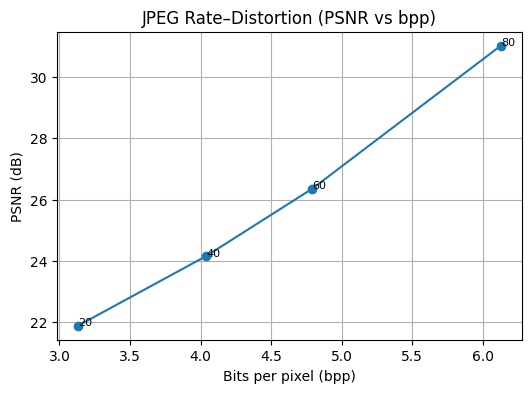

In [24]:
plt.figure(figsize=(6,4))
plt.plot(bpp, psnrs, marker="o")
for i, q in enumerate(qs):
    plt.text(bpp[i], psnrs[i], str(q), fontsize=8)
plt.xlabel("Bits per pixel (bpp)")
plt.ylabel("PSNR (dB)")
plt.title("JPEG Rate–Distortion (PSNR vs bpp)")
plt.grid(True)
plt.show()

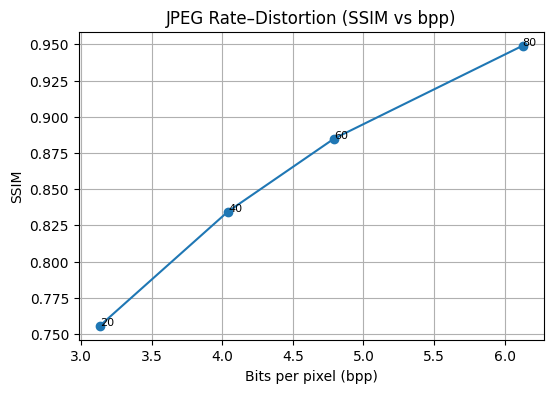

In [25]:
plt.figure(figsize=(6,4))
plt.plot(bpp, ssims, marker="o")
for i, q in enumerate(qs):
    plt.text(bpp[i], ssims[i], str(q), fontsize=8)
plt.xlabel("Bits per pixel (bpp)")
plt.ylabel("SSIM")
plt.title("JPEG Rate–Distortion (SSIM vs bpp)")
plt.grid(True)
plt.show()

##  Learned compression approach

We use a convolutional autoencoder:

Encoder maps image -> latent tensor z

We simulate compression with quantization in latent space 



##  Autoencoder model



In [26]:
class ConvAE(nn.Module):
    def __init__(self, in_ch=1, latent_ch=16):
        super().__init__()
        self.enc = nn.Sequential(
            nn.Conv2d(in_ch, 32, 3, stride=2, padding=1), nn.ReLU(inplace=True),  
            nn.Conv2d(32, 64, 3, stride=2, padding=1), nn.ReLU(inplace=True),     
            nn.Conv2d(64, latent_ch, 3, stride=1, padding=1),
        )
        self.dec = nn.Sequential(
            nn.ConvTranspose2d(latent_ch, 64, 4, stride=2, padding=1), nn.ReLU(inplace=True), 
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1), nn.ReLU(inplace=True),         
            nn.Conv2d(32, in_ch, 3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        z = self.enc(x)
        x_hat = self.dec(z)
        return x_hat, z


##  Quantization and channel simulation utilitie

In [27]:
def quantize_tensor(x, n_bits=4):
    x_t = torch.tanh(x)
    levels = 2 ** n_bits
    x_q = torch.round((x_t + 1) * (levels - 1) / 2) * (2 / (levels - 1)) - 1
    return x_q

In [28]:
def latent_packet_loss(z, drop_prob=0.1, packet_size=4):
    if drop_prob <= 0:
        return z

    B, C, H, W = z.shape
    z2 = z.clone()
    for b in range(B):
        for c in range(C):
            for i in range(0, H, packet_size):
                for j in range(0, W, packet_size):
                    if random.random() < drop_prob:
                        z2[b, c, i:i+packet_size, j:j+packet_size] = 0.0
    return z2

In [29]:
def latent_awgn(z, snr_db=20):
    if snr_db is None:
        return z
    power = z.pow(2).mean().item()
    snr = 10 ** (snr_db / 10)
    noise_power = power / max(snr, 1e-9)
    noise = torch.randn_like(z) * math.sqrt(noise_power)
    return z + noise

In [30]:
def estimate_latent_bpp(z, n_bits, img_h, img_w):
    C, Hs, Ws = z.shape
    total_bits = C * Hs * Ws * n_bits
    return total_bits / (img_h * img_w)

##  Training 

In [36]:
if info["n_channels"] == 1:
    IN_CH = 1
else:
    IN_CH = 3

LATENT_CH = 16
model = ConvAE(in_ch=IN_CH, latent_ch=LATENT_CH).to(DEVICE)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)


In [37]:
def run_epoch(loader, train=True):
    model.train(train)
    total_loss = 0.0
    n = 0
    for x, _ in loader:
        x = x.to(DEVICE)
        if train:
            opt.zero_grad()

        x_hat, _ = model(x)
        loss = F.mse_loss(x_hat, x)

        if train:
            loss.backward()
            opt.step()

        total_loss += loss.item() * x.size(0)
        n += x.size(0)
    return total_loss / max(n, 1)

EPOCHS = 10
for epoch in range(1, EPOCHS + 1):
    t0 = time.time()
    tr = run_epoch(train_loader, train=True)
    va = run_epoch(val_loader, train=False)
    dt = time.time() - t0
    print(f"Epoch {epoch:02d} | train {tr:.5f} | val {va:.5f} | {dt:.1f}s")


c:\Users\ASUS\miniconda3\envs\torch_gpu\lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 01 | train 0.01634 | val 0.00970 | 29.7s
Epoch 02 | train 0.00684 | val 0.00569 | 29.7s
Epoch 03 | train 0.00419 | val 0.00348 | 30.0s
Epoch 04 | train 0.00253 | val 0.00204 | 30.3s
Epoch 05 | train 0.00164 | val 0.00143 | 30.3s
Epoch 06 | train 0.00099 | val 0.00077 | 30.3s
Epoch 07 | train 0.00065 | val 0.00040 | 30.5s
Epoch 08 | train 0.00031 | val 0.00025 | 31.0s
Epoch 09 | train 0.00023 | val 0.00017 | 82.9s
Epoch 10 | train 0.00020 | val 0.00021 | 62.4s


## Visual check: original vs reconstructed


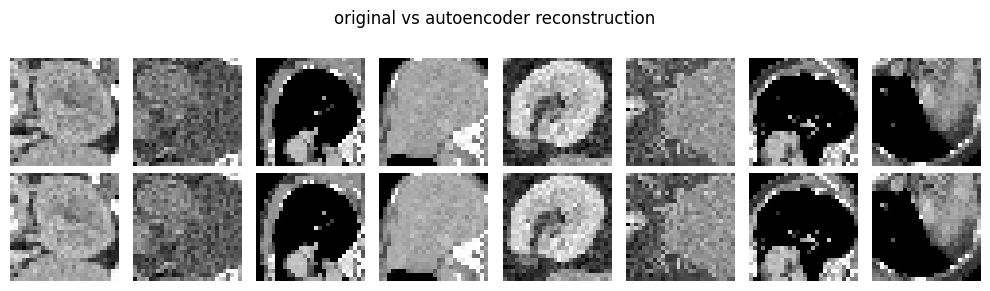

In [38]:
model.eval()
x, _ = next(iter(test_loader))
x = x[:8].to(DEVICE)

with torch.no_grad():
    x_hat, _ = model(x)

x_np = x.cpu().permute(0,2,3,1).numpy()
xhat_np = x_hat.cpu().permute(0,2,3,1).numpy()

plt.figure(figsize=(10,3))
for i in range(8):
    ax = plt.subplot(2,8,i+1)
    ax.imshow(x_np[i].squeeze(), cmap="gray" if IN_CH==1 else None)
    ax.axis("off")
    ax = plt.subplot(2,8,8+i+1)
    ax.imshow(xhat_np[i].squeeze(), cmap="gray" if IN_CH==1 else None)
    ax.axis("off")
plt.suptitle("original vs autoencoder reconstruction")
plt.tight_layout()
plt.show()


## Evaluation function for the learned compressor


In [39]:
BITS_LIST = [2, 3, 4, 6, 8]

In [ ]:
def eval_learned(loader, max_batches=8, drop_prob=0.0, snr_db=None):
    model.eval()
    rows = []
    batches = 0

    for x, _ in loader:
        x = x.to(DEVICE)

        with torch.no_grad():
            x_hat, z = model(x)

        for n_bits in BITS_LIST:
            with torch.no_grad():
                zq = quantize_tensor(z, n_bits=n_bits)
                zc = latent_packet_loss(zq, drop_prob=drop_prob, packet_size=4)
                zc = latent_awgn(zc, snr_db=snr_db)
                x_rec = model.dec(zc)

            x0 = x.cpu().permute(0, 2, 3, 1).numpy()
            xr = x_rec.cpu().permute(0, 2, 3, 1).numpy()

            psnrs, ssims, bpps = [], [], []

            for i in range(x0.shape[0]):
                orig = x0[i].astype(np.float32)
                rec  = xr[i].astype(np.float32)

                psnrs.append(psnr(orig, rec))

                if IN_CH == 1:
                    ssims.append(compute_ssim(orig.squeeze(), rec.squeeze()))
                else:
                    ssims.append(compute_ssim(orig, rec))

                bpps.append(
                    estimate_latent_bpp(
                        z[i],                     
                        n_bits,
                        img_h=orig.shape[0],
                        img_w=orig.shape[1],
                    )
                )

            rows.append({
                "n_bits": n_bits,
                "drop_prob": drop_prob,
                "snr_db": snr_db if snr_db is not None else "inf",
                "bpp_mean": float(np.mean(bpps)),
                "psnr_mean": float(np.mean(psnrs)),
                "ssim_mean": float(np.mean(ssims)),
            })

        batches += 1
        if batches >= max_batches:
            break

    grouped = {}
    for r in rows:
        key = (r["n_bits"], r["drop_prob"], r["snr_db"])
        grouped.setdefault(key, {"bpp": [], "psnr": [], "ssim": []})
        grouped[key]["bpp"].append(r["bpp_mean"])
        grouped[key]["psnr"].append(r["psnr_mean"])
        grouped[key]["ssim"].append(r["ssim_mean"])

    final = []
    for (n_bits, dp, snr), v in grouped.items():
        final.append({
            "n_bits": n_bits,
            "drop_prob": dp,
            "snr_db": snr,
            "bpp_mean": float(np.mean(v["bpp"])),
            "psnr_mean": float(np.mean(v["psnr"])),
            "ssim_mean": float(np.mean(v["ssim"])),
        })

    final.sort(key=lambda d: (d["drop_prob"], str(d["snr_db"]), d["n_bits"]))
    return final


## Learned compression: clean channel (no loss, no noise)


In [43]:
learned_clean = eval_learned(test_loader, max_batches=8, drop_prob=0.0, snr_db=None)



In [44]:
learned_clean

[{'n_bits': 2,
  'drop_prob': 0.0,
  'snr_db': 'inf',
  'bpp_mean': 2.0,
  'psnr_mean': 15.801884531974792,
  'ssim_mean': 0.5538100293016941},
 {'n_bits': 3,
  'drop_prob': 0.0,
  'snr_db': 'inf',
  'bpp_mean': 3.0,
  'psnr_mean': 16.79867124557495,
  'ssim_mean': 0.6120093299549547},
 {'n_bits': 4,
  'drop_prob': 0.0,
  'snr_db': 'inf',
  'bpp_mean': 4.0,
  'psnr_mean': 16.910818576812744,
  'ssim_mean': 0.6177367677865666},
 {'n_bits': 6,
  'drop_prob': 0.0,
  'snr_db': 'inf',
  'bpp_mean': 6.0,
  'psnr_mean': 16.906009912490845,
  'ssim_mean': 0.6179840245888281},
 {'n_bits': 8,
  'drop_prob': 0.0,
  'snr_db': 'inf',
  'bpp_mean': 8.0,
  'psnr_mean': 16.909472465515137,
  'ssim_mean': 0.6181487206876866}]

##  Plot learned rate–distortion (clean channel)


In [45]:
bpp = [r["bpp_mean"] for r in learned_clean]
psnrs = [r["psnr_mean"] for r in learned_clean]
ssims = [r["ssim_mean"] for r in learned_clean]
bits = [r["n_bits"] for r in learned_clean]

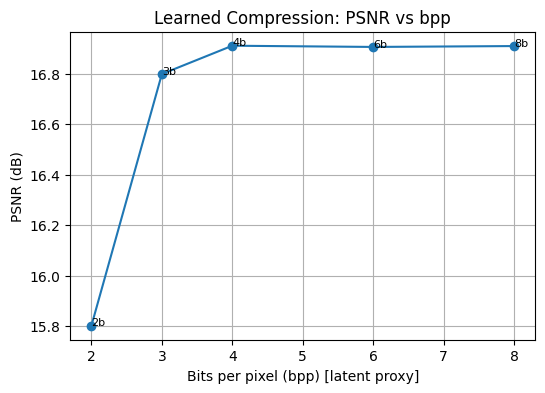

In [46]:
plt.figure(figsize=(6,4))
plt.plot(bpp, psnrs, marker="o")
for i, nb in enumerate(bits):
    plt.text(bpp[i], psnrs[i], f"{nb}b", fontsize=8)
plt.xlabel("Bits per pixel (bpp) [latent proxy]")
plt.ylabel("PSNR (dB)")
plt.title("Learned Compression: PSNR vs bpp")
plt.grid(True)
plt.show()

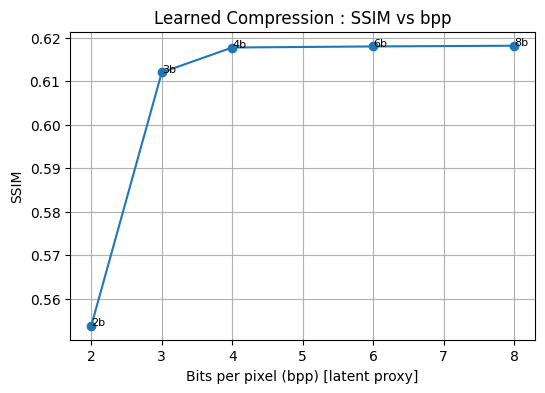

In [47]:

plt.figure(figsize=(6,4))
plt.plot(bpp, ssims, marker="o")
for i, nb in enumerate(bits):
    plt.text(bpp[i], ssims[i], f"{nb}b", fontsize=8)
plt.xlabel("Bits per pixel (bpp) [latent proxy]")
plt.ylabel("SSIM")
plt.title("Learned Compression : SSIM vs bpp")
plt.grid(True)
plt.show()


## Channel stress tests

We add packet loss and latent noise to mimic unreliable transmission.


In [48]:
learned_loss_5 = eval_learned(test_loader, max_batches=8, drop_prob=0.05, snr_db=None)
learned_loss_10 = eval_learned(test_loader, max_batches=8, drop_prob=0.10, snr_db=None)
learned_noise_20 = eval_learned(test_loader, max_batches=8, drop_prob=0.0, snr_db=20)
learned_noise_10 = eval_learned(test_loader, max_batches=8, drop_prob=0.0, snr_db=10)




In [49]:
learned_loss_10[:3], learned_noise_10[:3]

([{'n_bits': 2,
   'drop_prob': 0.1,
   'snr_db': 'inf',
   'bpp_mean': 2.0,
   'psnr_mean': 14.277999877929688,
   'ssim_mean': 0.46947137167744213},
  {'n_bits': 3,
   'drop_prob': 0.1,
   'snr_db': 'inf',
   'bpp_mean': 3.0,
   'psnr_mean': 14.806380987167358,
   'ssim_mean': 0.5075475912402482},
  {'n_bits': 4,
   'drop_prob': 0.1,
   'snr_db': 'inf',
   'bpp_mean': 4.0,
   'psnr_mean': 14.807325959205627,
   'ssim_mean': 0.506574340579706}],
 [{'n_bits': 2,
   'drop_prob': 0.0,
   'snr_db': 10,
   'bpp_mean': 2.0,
   'psnr_mean': 14.07688558101654,
   'ssim_mean': 0.46440428060367733},
  {'n_bits': 3,
   'drop_prob': 0.0,
   'snr_db': 10,
   'bpp_mean': 3.0,
   'psnr_mean': 14.829084753990173,
   'ssim_mean': 0.5073641391425812},
  {'n_bits': 4,
   'drop_prob': 0.0,
   'snr_db': 10,
   'bpp_mean': 4.0,
   'psnr_mean': 14.925650119781494,
   'ssim_mean': 0.5121155985682582}])

## Robustness plots

In [50]:
def plot_compare(curves, labels, metric="psnr_mean", title=""):
    plt.figure(figsize=(6,4))
    for curve, label in zip(curves, labels):
        xs = [r["bpp_mean"] for r in curve]
        ys = [r[metric] for r in curve]
        plt.plot(xs, ys, marker="o", label=label)
    plt.xlabel("bpp [latent proxy]")
    plt.ylabel("PSNR (dB)" if metric=="psnr_mean" else "SSIM")
    plt.title(title)
    plt.grid(True)
    plt.legend()
    plt.show()

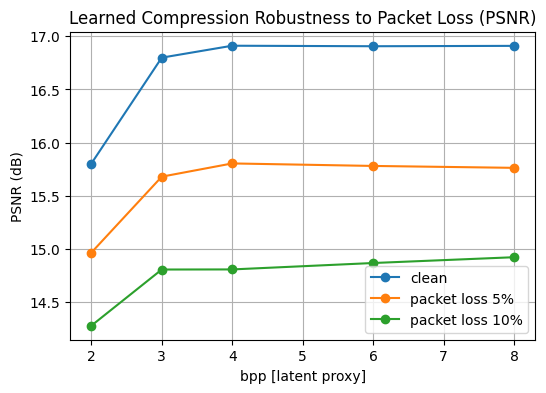

In [51]:
plot_compare(
    [learned_clean, learned_loss_5, learned_loss_10],
    ["clean", "packet loss 5%", "packet loss 10%"],
    metric="psnr_mean",
    title="Learned Compression Robustness to Packet Loss (PSNR)"
)

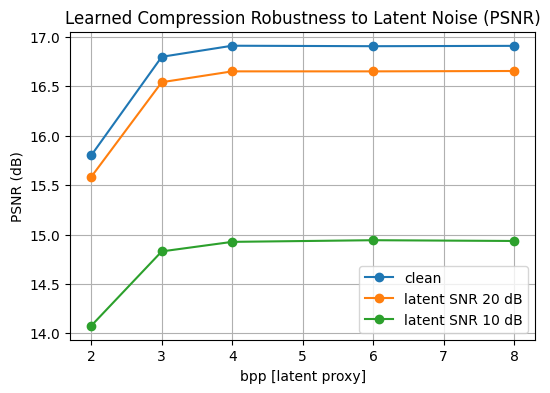

In [52]:
plot_compare(
    [learned_clean, learned_noise_20, learned_noise_10],
    ["clean", "latent SNR 20 dB", "latent SNR 10 dB"],
    metric="psnr_mean",
    title="Learned Compression Robustness to Latent Noise (PSNR)"
)